In [1]:
########################################
# Packages
########################################
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap

import math

import statistics

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist
from scipy.stats import beta

import seaborn as sns

In [2]:
from data_processing import SHARKDataProcessor
processor = SHARKDataProcessor()

# Define subvolume IDs and HDF5 file paths
sv_list = np.arange(64)
sharkfiles = [f'extracted_data_z=0/199/{sv}/galaxies.hdf5' for sv in sv_list] #DEFINE FILE

# Output shark_csv dataframe
shark_csv = processor.process_all_subvolumes(sv_list, sharkfiles)
print(shark_csv.head())

  ID_galaxy ID_subhalo    ID_subhalo_tree ID_halo  sv  type    Mhalo_host  \
0   0_12323        0_1  0_199000000000184     0_1   0     0  1.553645e+12   
1   0_41884        0_2  0_199000000032613     0_1   0     1  1.553645e+12   
2   0_25337        0_4  0_199000000000239     0_2   0     0  1.013176e+12   
3   0_12324        0_4  0_199000000000239     0_2   0     2  1.013176e+12   
4  0_325815        0_5  0_199000000032723     0_2   0     1  1.013176e+12   

          Mhalo   Mstar_bulge    Mstar_disc  ...  SFR_bulge  SFR_disc  \
0  1.406334e+12  4.406725e+10  8.090279e+09  ...   0.239161  8.448190   
1  1.132662e+11  6.663850e+07  3.927870e+08  ...   0.000000  0.045958   
2  7.889350e+11  1.441911e+10  7.342129e+06  ...   5.469577  0.054259   
3  4.321138e+10  4.237961e+08  9.966004e+08  ...   0.000000  0.128186   
4  2.242409e+11  4.860634e+08  7.437644e+08  ...   0.000000  0.316807   

    SFR_all           MBH  MBHacc_cold    MBHacc_hot    MBHacc_all  \
0  8.687351  2.992633e+07   

In [3]:
########################################
# gal_sv settings
########################################
# type: galaxy type; =0 for centrals; =1 for satellites that reside in well identified subhalos; =2 for orphan satellites

shark_csv_centrals = shark_csv[(shark_csv['type'] == 0)] ######## Centrals only
shark_csv_satellites = shark_csv[(shark_csv['type'] == 1)] ######## Satellites only
shark_csv_satANDor = shark_csv[(shark_csv['type'].isin([1, 2]))] ######## Satellites and Orphans

########################################
# Late and Early Type Galaxies
########################################
valid_data = shark_csv['Mstar_all'] > 0

# Late-Type Galaxies (D/T > 0.5)
shark_csv_late = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] > 0.5) & valid_data
# Early-Type Galaxies (D/T <= 0.5) -elliptical-
shark_csv_early = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] <= 0.5) & valid_data  

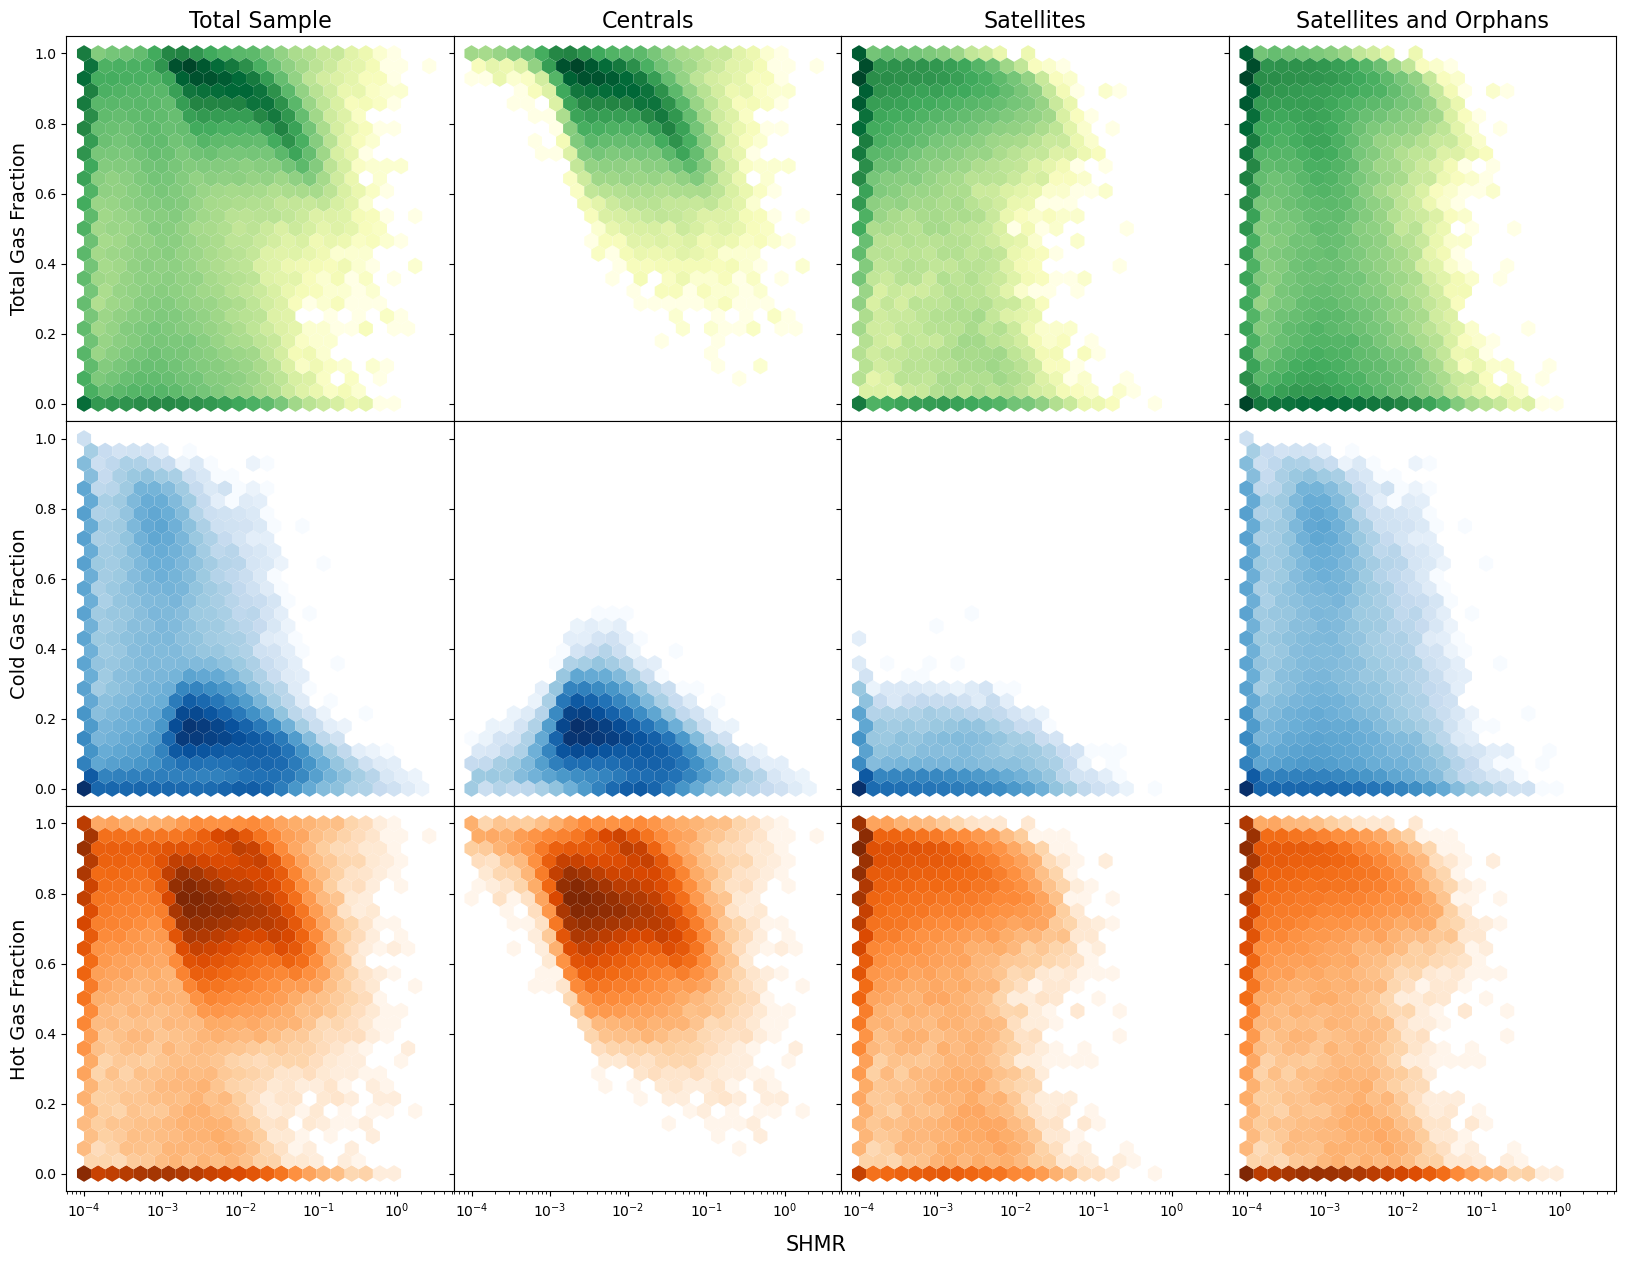

In [4]:
# vs. SHMR
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction by SHMR
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        SHMR = data['Mstar_all'] / data['Mhalo_host']
        SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset
        
        # Plot density hexbin
        axs[row, col].hexbin(SHMR, gas_fraction_subset, gridsize=25, xscale='log',
                             reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
                             cmap=colours[row], extent=(-4, 0.5, 0, 1))
        #axs[row, col].scatter(SHMR, gas_fraction_subset, color='Black', alpha=0.5)
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'SHMR', ha='center', fontsize=15)

# Show the plot
plt.show()

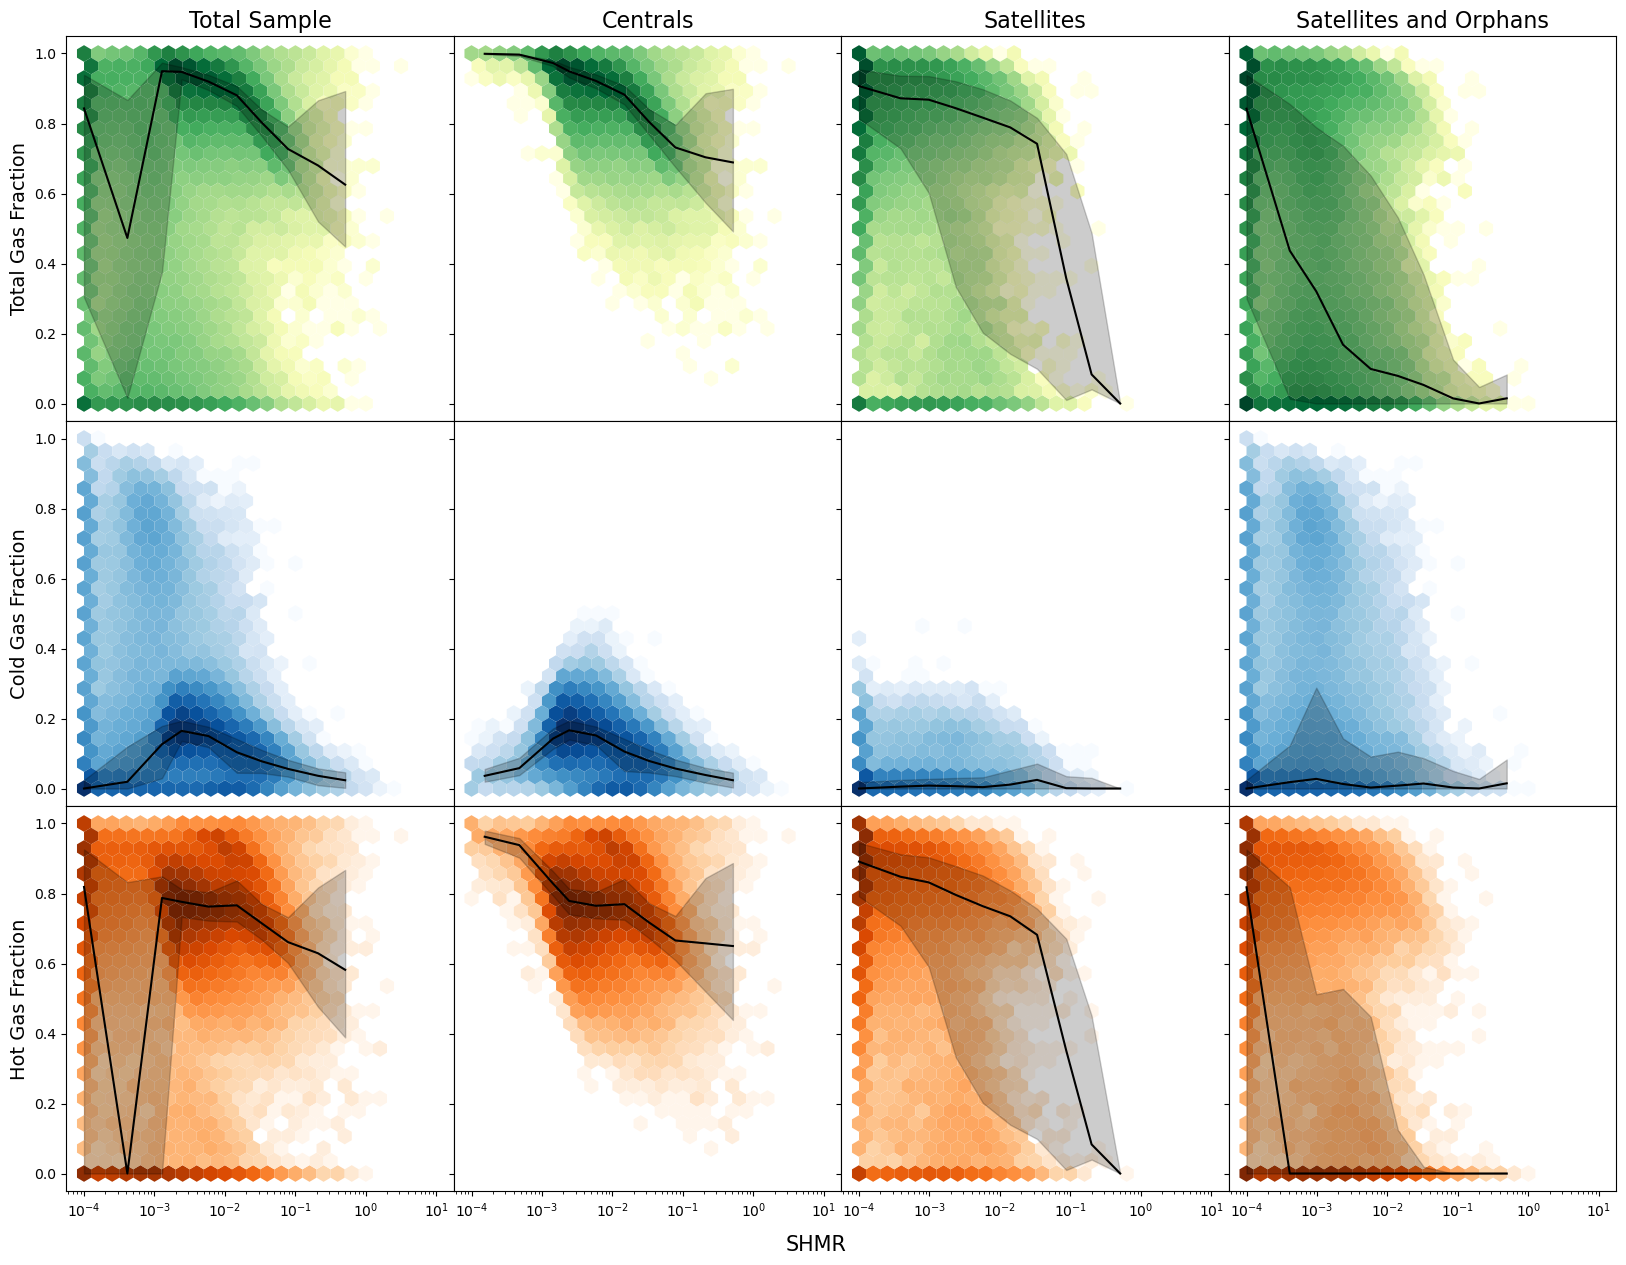

In [82]:
# VS. SHMR -- IQR Visualization
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        
########################################

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        SHMR = data['Mstar_all'] / data['Mhalo_host']
        SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold
        
        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset

        # Calculate min and max log values of Stellar Mass 
        lowLog = math.log10(SHMR.min())
        highLog = math.log10(SHMR.max())
        #print("lowlog:", lowLog)
        #print("highlog:", highLog)
        
        # Round to the nearest whole number for log binning
        lowLog = round(lowLog, 0)
        highLog = round(highLog, 0)

        # Create log bins
        num_bins = 10
        logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

        ########################################
        # Median Plotting using global log bins
        ########################################
        # MEDIAN for y-values
        result = binned_statistic(SHMR, gas_fraction_subset, statistic='median', bins=logBins)
        bin_medians = result.statistic

        # Calculate xVals by finding the median stellar mass value within each bin
        xVals = []

        for j in range(len(logBins) - 1):
            # Filter data points within the current bin
            bin_data = gas_fraction_subset[(SHMR >= logBins[j]) & (SHMR < logBins[j+1])]
            
            if len(bin_data) > 0:
                # Median x-value
                xVals.append(np.median(SHMR[(SHMR >= logBins[j]) & (SHMR < logBins[j+1])]))
            else:
                xVals.append(np.nan)
                print('append error')

        # PERCENTILES
        # 25th percentile
        # 25th percentile
        percentile_25 = binned_statistic(SHMR, gas_fraction_subset, statistic=lambda values: np.percentile(values, 25), bins=logBins)
        p25 = np.array(percentile_25.statistic)

        # 75th percentile
        percentile_75 = binned_statistic(SHMR, gas_fraction_subset, statistic=lambda values: np.percentile(values, 75), bins=logBins)
        p75 = np.array(percentile_75.statistic)

        # Convert xVals, bin_medians to numpy arrays
        xVals = np.array(xVals)
        bin_medians = np.array(bin_medians)

        # Calculate valid bins
        valid_bins = ~np.isnan(xVals) & ~np.isnan(bin_medians) & ~np.isnan(p25) & ~np.isnan(p75)

        # Filter arrays using valid_bins
        xVals = xVals[valid_bins]
        bin_medians = bin_medians[valid_bins]
        p25 = p25[valid_bins]
        p75 = p75[valid_bins]

        # Debug shapes
        #print(f"xVals shape: {xVals.shape}")
        #print(f"p25 shape: {p25.shape}")
        #print(f"p75 shape: {p75.shape}")

        # Plot density hexbin
        axs[row, col].hexbin(
            SHMR, gas_fraction_subset, gridsize=25, xscale='log',
            reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
            cmap=colours[row], extent=(-4, 1, 0, 1)
        )

        # Plot percentiles
        axs[row, col].fill_between(xVals, p25, p75, color='black', alpha=0.2)

        # Configure axes
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Median line without markers
        axs[row, col].plot(
            xVals, 
            bin_medians, 
            color='black',         # Line color
            linewidth=1.5,         # Line width
            linestyle="-"          # Line style (solid)
        )

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'SHMR', ha='center', fontsize=15)

# Show the plot
plt.show()

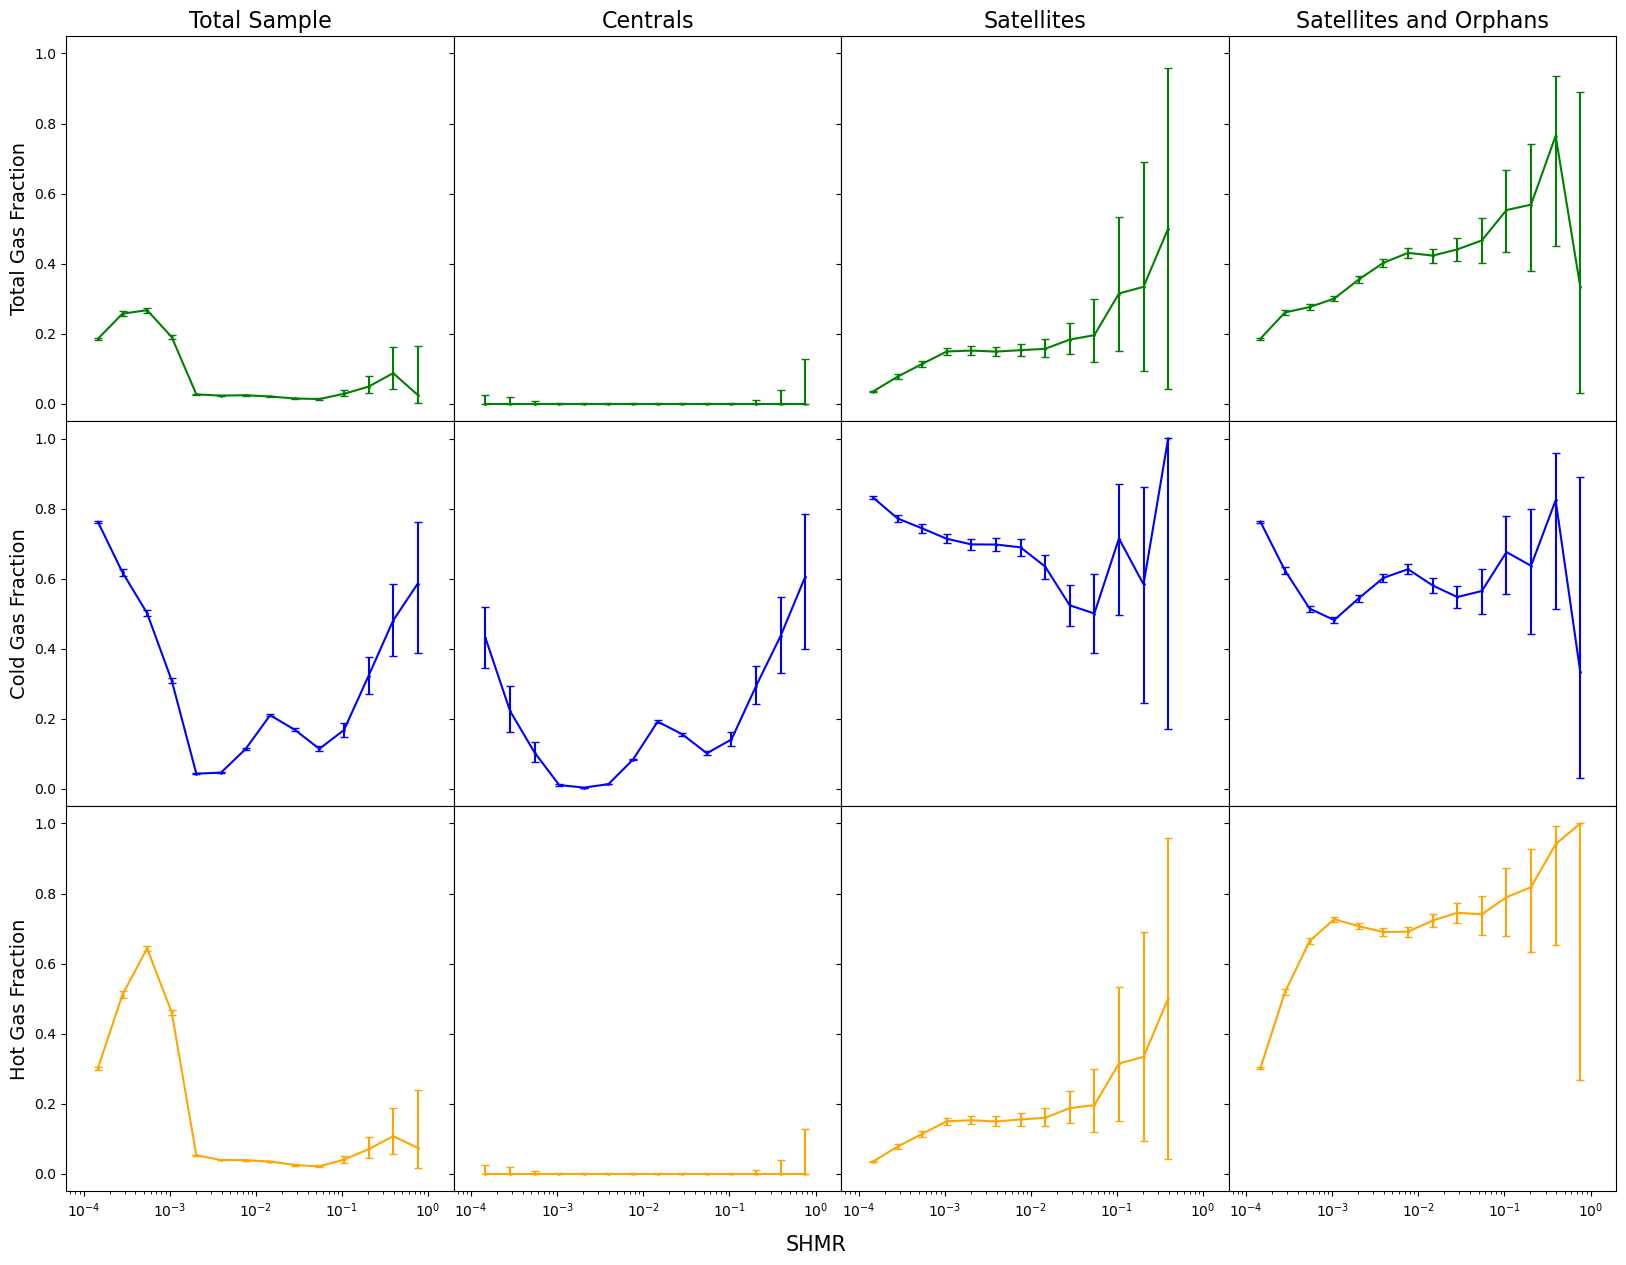

221646


In [106]:
# VS. SHMR -- ZERO prop. + Bayseian CI
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

def zero_fraction(values, effective_zero=0.025):
    """Compute fraction of values below effective_zero."""
    if len(values) == 0:
        return np.nan  # Handle empty bins
    count_below = np.count_nonzero(values < effective_zero)  # Count values below threshold
    return count_below / len(values)

# Compute gas fractions
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = shark_csv['Mhotgas'] / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = shark_csv['Mcoldgas_all'] / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ['Green', 'Blue', 'Orange']

# Create figure and subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

SHMR = shark_csv['Mstar_all'] / shark_csv['Mhalo_host']
SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

# Compute log bins
lowLog = math.log10(SHMR.min())
highLog = math.log10(SHMR.max())
lowLog, highLog = round(lowLog, 0), round(highLog, 0)
num_bins = 14
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# Loop through gas fraction types and datasets
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):
        gas_fraction_subset = gas_fraction[data.index]
        SHMR_subset = SHMR[data.index]  # Fix: Match the filtered dataset

        result = binned_statistic(
            SHMR_subset, gas_fraction_subset, 
            statistic=lambda x: zero_fraction(x, effective_zero=0.025), 
            bins=logBins
        )
        zero_fractions, bin_edges = result.statistic, result.bin_edges
        xVals = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin midp

        # Filter valid bins
        valid_bins = ~np.isnan(zero_fractions)
        xVals, zero_fractions = xVals[valid_bins], zero_fractions[valid_bins]

        #### GPT CHANGE: Bayesian Confidence Interval Calculation
        ci_lower, ci_upper, xVals_fixed = [], [], []  # Store valid x-values separately
        
        for j in range(len(logBins) - 1):
            bin_data = gas_fraction_subset[(SHMR_subset >= logBins[j]) & (SHMR_subset < logBins[j+1])]
            
            if len(bin_data) > 0:
                k = np.count_nonzero(bin_data < 0.025)  # Correct success count
                n = len(bin_data)  # Total trials
                xVals_fixed.append((logBins[j] + logBins[j+1]) / 2)  # Use bin midpoint
                
                # Compute Bayesian credible intervals
                lower = beta.ppf(0.005, k + 1, n - k + 1)
                upper = beta.ppf(0.995, k + 1, n - k + 1)
                ci_lower.append(lower)
                ci_upper.append(upper)
            
        # Plot the proportion of values below threshold
        yerr = np.abs(np.vstack((zero_fractions - ci_lower, ci_upper - zero_fractions)))
        
        axs[row, col].errorbar(xVals_fixed, 
            zero_fractions, 
            yerr=yerr, 
            fmt='o', 
            color=colours[row],
            linestyle='-',
            markersize=1,
            capsize=3
        )

        # Set axes properties
        axs[row, col].set_xscale('log')
        axs[row, col].set_yscale('linear')
        axs[row, col].set_xlim(10**-4.2, 10**0.3)  # #### GPT CHANGE: Manually set x-axis limits
        axs[row, col].set_ylim(-0.05, 1.05)  # #### GPT CHANGE: Manually set y-axis limits
        
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'SHMR', ha='center', fontsize=15)
plt.show()

print(len(SHMR_subset))

lowlog: 9.816054136206564
highlog: 14.972738287330559
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)


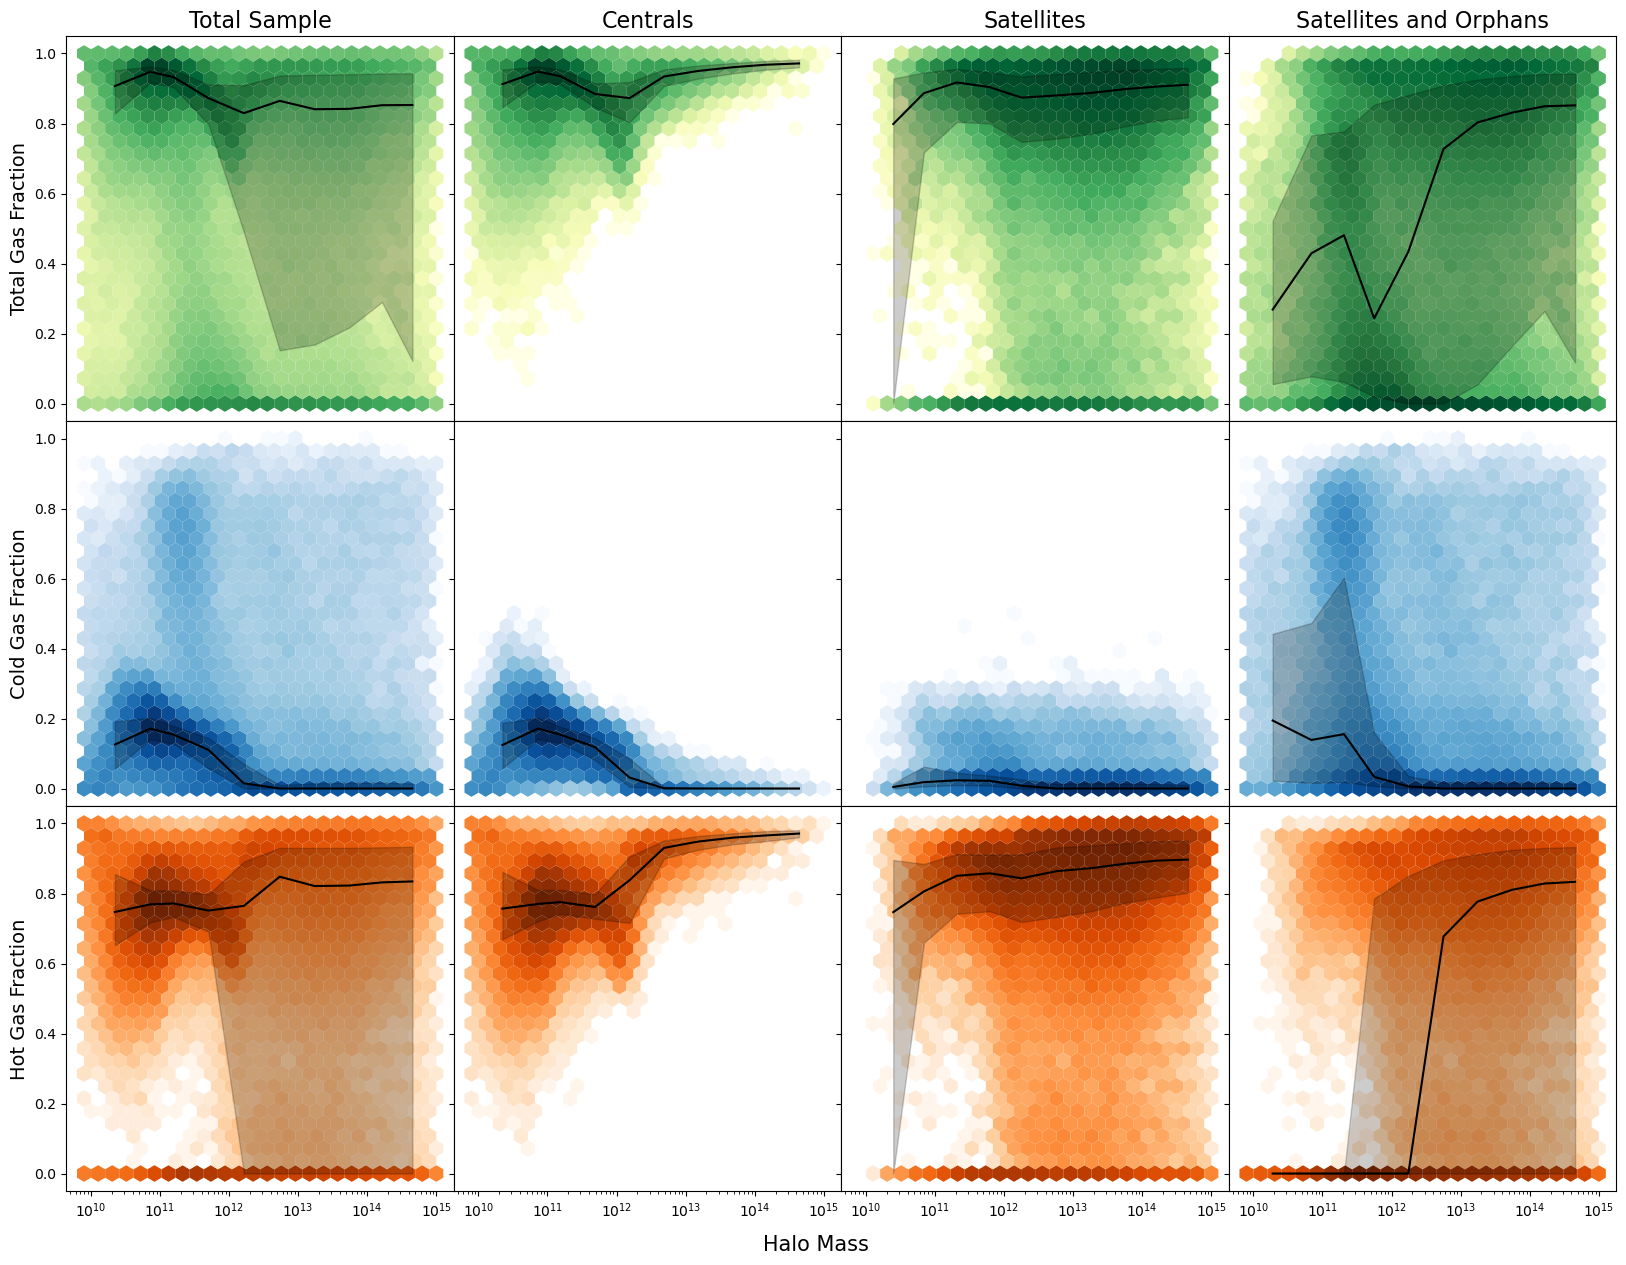

In [9]:
# VS. shark_csv['Mhalo_host'] -- IQR Visualization
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

########################################
# Global log bin calculation
########################################
# Calculate min and max log values of Stellar Mass 
lowLog = math.log10(data['Mhalo_host'].min())
highLog = math.log10(data['Mhalo_host'].max())
print("lowlog:", lowLog)
print("highlog:", highLog)
        
# Round to the nearest whole number for log binning
lowLog = round(lowLog, 0)
highLog = round(highLog, 0)

# Create log bins
num_bins = 10
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)
########################################

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        HALOmass = data['Mhalo_host']
        #SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold
        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset

        ########################################
        # Median Plotting using global log bins
        ########################################
        # MEDIAN for y-values
        result = binned_statistic(HALOmass, gas_fraction_subset, statistic='median', bins=logBins)
        bin_medians = result.statistic

        # Calculate xVals by finding the median stellar mass value within each bin
        xVals = []

        for j in range(len(logBins) - 1):
            # Filter data points within the current bin
            bin_data = gas_fraction_subset[(HALOmass >= logBins[j]) & (HALOmass < logBins[j+1])]
            
            if len(bin_data) > 0:
                # Median x-value
                xVals.append(np.median(HALOmass[(HALOmass >= logBins[j]) & (HALOmass < logBins[j+1])]))
            else:
                xVals.append(np.nan)
                print('append error')

        # PERCENTILES
        # 25th percentile
        # 25th percentile
        percentile_25 = binned_statistic(HALOmass, gas_fraction_subset, statistic=lambda values: np.percentile(values, 25), bins=logBins)
        p25 = np.array(percentile_25.statistic)

        # 75th percentile
        percentile_75 = binned_statistic(HALOmass, gas_fraction_subset, statistic=lambda values: np.percentile(values, 75), bins=logBins)
        p75 = np.array(percentile_75.statistic)

        # Convert xVals, bin_medians to numpy arrays
        xVals = np.array(xVals)
        bin_medians = np.array(bin_medians)

        # Calculate valid bins
        valid_bins = ~np.isnan(xVals) & ~np.isnan(bin_medians) & ~np.isnan(p25) & ~np.isnan(p75)

        # Filter arrays using valid_bins
        xVals = xVals[valid_bins]
        bin_medians = bin_medians[valid_bins]
        p25 = p25[valid_bins]
        p75 = p75[valid_bins]

        # Debug shapes
        print(f"xVals shape: {xVals.shape}")
        print(f"p25 shape: {p25.shape}")
        print(f"p75 shape: {p75.shape}")

        # Plot density hexbin
        axs[row, col].hexbin(
            HALOmass, gas_fraction_subset, gridsize=25, xscale='log',
            reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
            cmap=colours[row], extent=(9.9, 15, 0, 1)
        )

        # Plot percentiles
        axs[row, col].fill_between(xVals, p25, p75, color='black', alpha=0.2)

        # Configure axes
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Median line without markers
        axs[row, col].plot(
            xVals, 
            bin_medians, 
            color='black',         # Line color
            linewidth=1.5,         # Line width
            linestyle="-"          # Line style (solid)
        )

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'Halo Mass', ha='center', fontsize=15)

# Show the plot
plt.show()

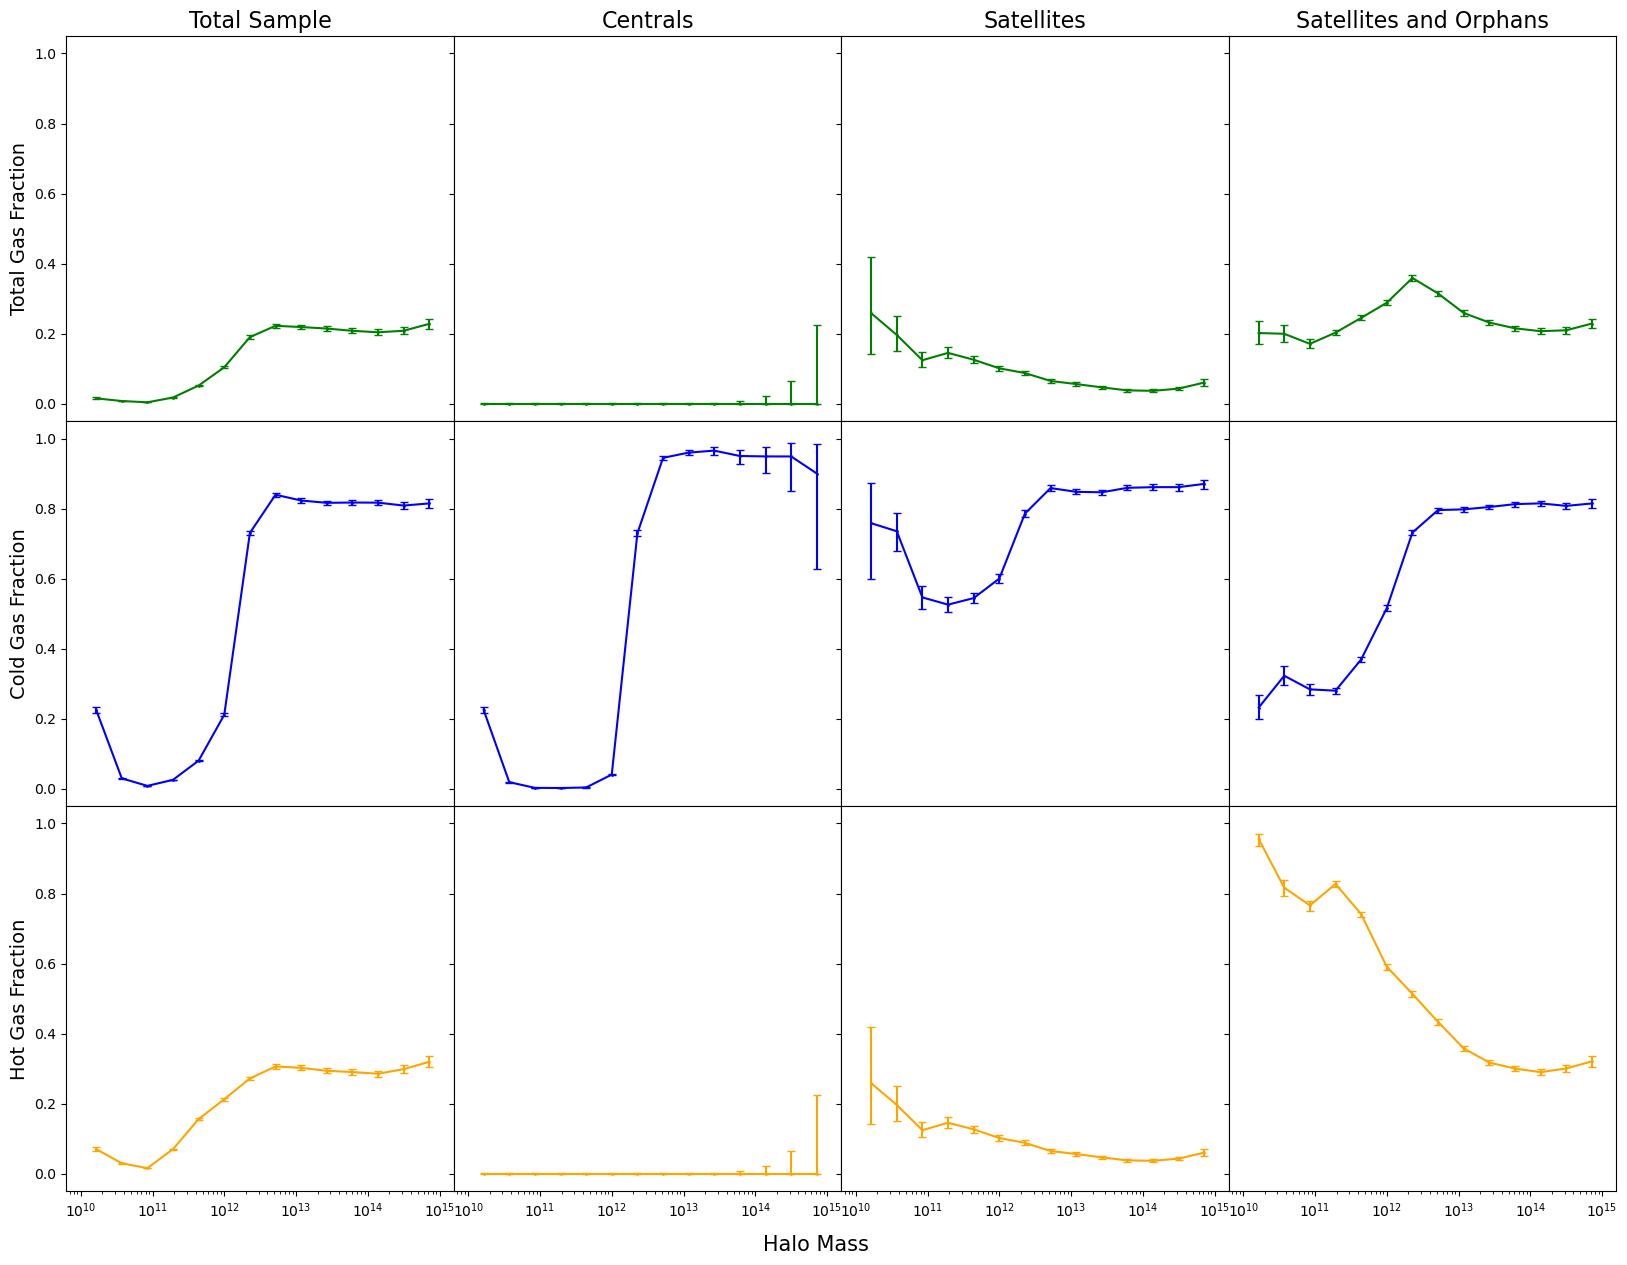

In [74]:
# VS. shark_csv['Mhalo_host'] -- ZERO prop. + Bayseian CI
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

def zero_fraction(values, effective_zero=0.025):
    """Compute fraction of values below effective_zero."""
    if len(values) == 0:
        return np.nan  # Handle empty bins
    count_below = np.count_nonzero(values < effective_zero)  # Count values below threshold
    return count_below / len(values)

# Compute gas fractions
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = shark_csv['Mhotgas'] / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = shark_csv['Mcoldgas_all'] / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ['Green', 'Blue', 'Orange']

# Create figure and subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Compute log bins
lowLog = math.log10(shark_csv['Mhalo_host'].min())
highLog = math.log10(shark_csv['Mhalo_host'].max())
lowLog, highLog = round(lowLog, 0), round(highLog, 0)
num_bins = 14
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# Loop through gas fraction types and datasets
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):
        HALOmass = data['Mhalo_host']
        gas_fraction_subset = gas_fraction[data.index]
        
        # Compute zero fraction per bin
        result = binned_statistic(
            HALOmass, gas_fraction_subset, 
            statistic=lambda x: zero_fraction(x, effective_zero=0.025), 
            bins=logBins
        )
        zero_fractions, bin_edges = result.statistic, result.bin_edges
        xVals = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin midpoints

        # Filter valid bins
        valid_bins = ~np.isnan(zero_fractions)
        xVals, zero_fractions = xVals[valid_bins], zero_fractions[valid_bins]

        #### GPT CHANGE: Bayesian Confidence Interval Calculation
        ci_lower, ci_upper, xVals_fixed = [], [], []  # Store valid x-values separately
        
        for j in range(len(logBins) - 1):
            bin_data = gas_fraction_subset[(HALOmass >= logBins[j]) & (HALOmass < logBins[j+1])]
            
            if len(bin_data) > 0:
                k = np.count_nonzero(bin_data < 0.025)  # Correct success count
                n = len(bin_data)  # Total trials
                xVals_fixed.append((logBins[j] + logBins[j+1]) / 2)  # Use bin midpoint
                
                # Compute Bayesian credible intervals
                lower = beta.ppf(0.005, k + 1, n - k + 1)
                upper = beta.ppf(0.995, k + 1, n - k + 1)
                ci_lower.append(lower)
                ci_upper.append(upper)
            
        # Plot the proportion of values below threshold
        yerr = np.abs(np.vstack((zero_fractions - ci_lower, ci_upper - zero_fractions)))
        
        axs[row, col].errorbar(xVals_fixed, 
            zero_fractions, 
            yerr=yerr, 
            fmt='o', 
            color=colours[row],
            linestyle='-',
            markersize=1,
            capsize=3
        )

        # Set axes properties
        axs[row, col].set_xscale('log')
        axs[row, col].set_yscale('linear')
        axs[row, col].set_xlim(10**9.8, 10**15.2)  # #### GPT CHANGE: Manually set x-axis limits
        axs[row, col].set_ylim(-0.05, 1.05)  # #### GPT CHANGE: Manually set y-axis limits
        
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'Halo Mass', ha='center', fontsize=15)
plt.show()

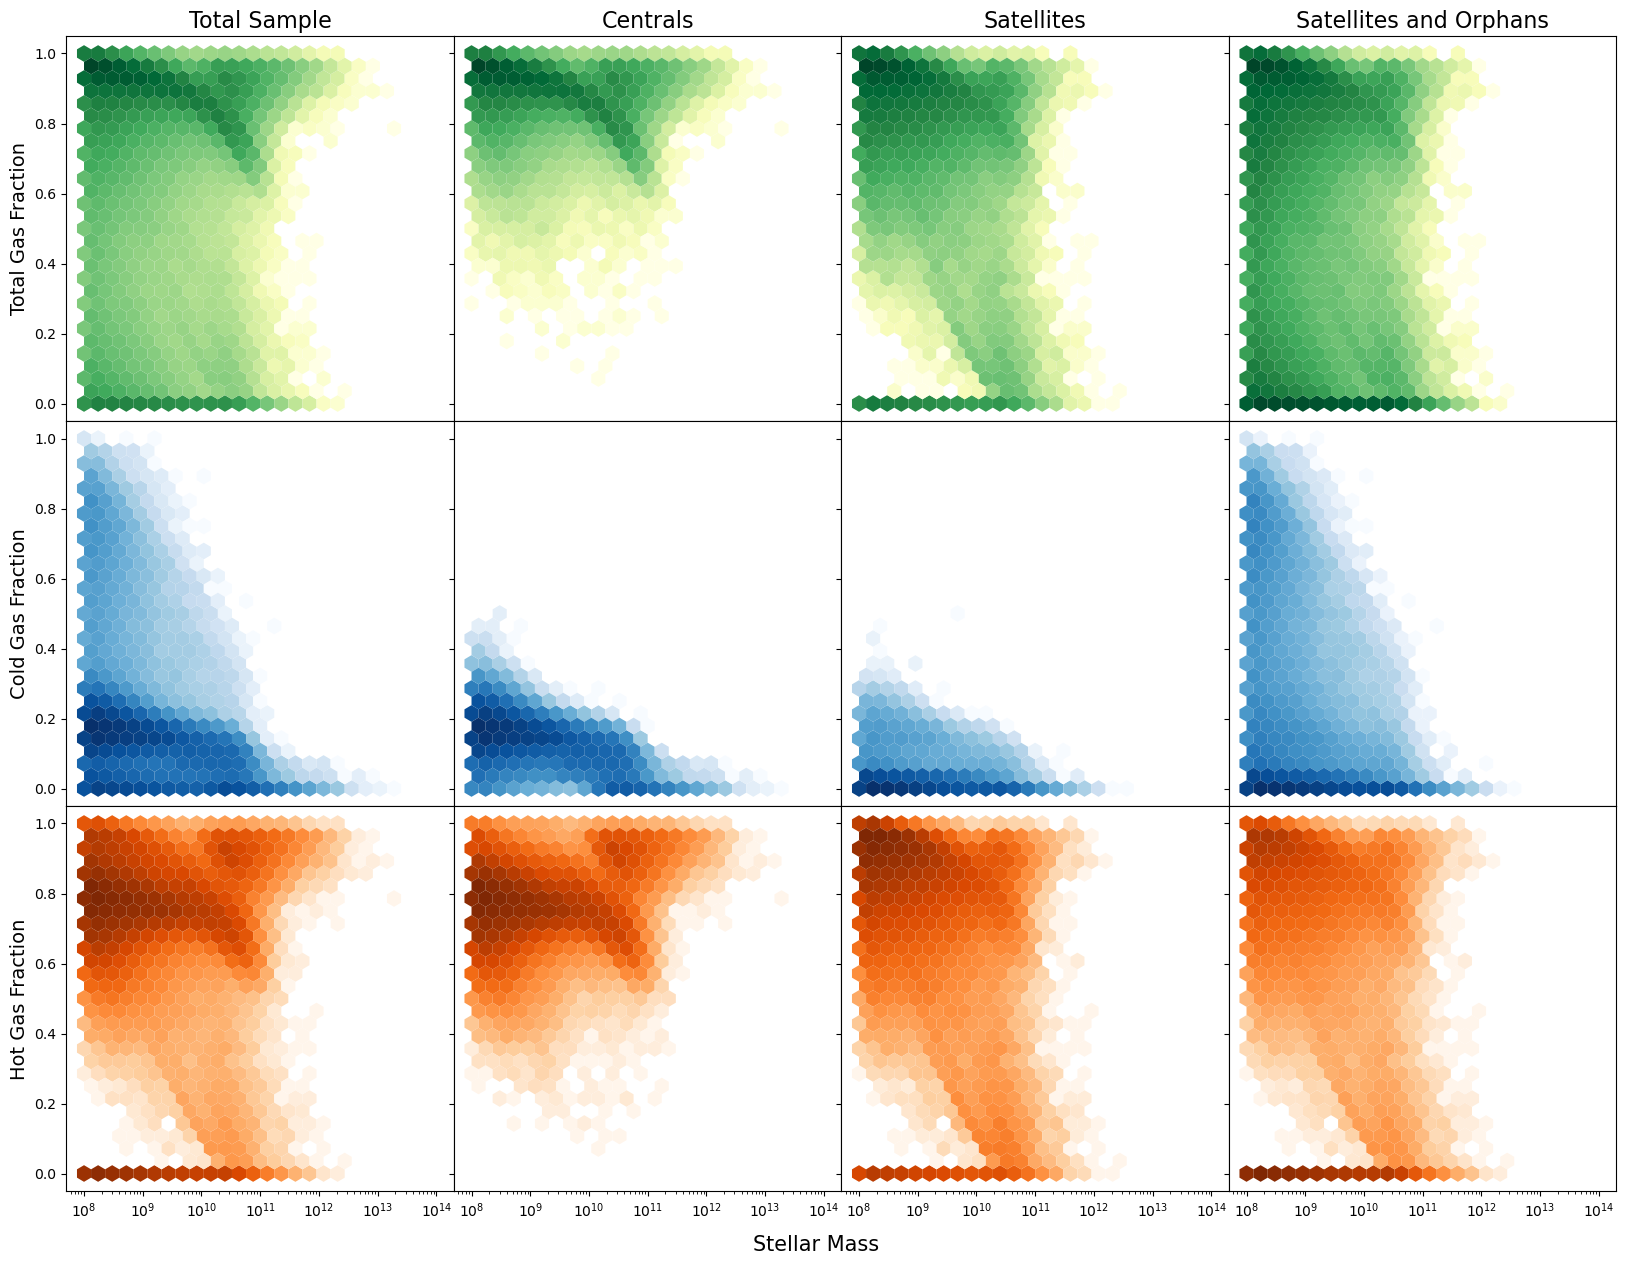

In [48]:
# VS. shark_csv['Mstar_all']
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        STELLARmass = data['Mstar_all']
        #SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold

        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset
        
        # Plot density hexbin
        axs[row, col].hexbin(STELLARmass, gas_fraction_subset, gridsize=25, xscale='log',
                             reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
                             cmap=colours[row], extent=(8, 14, 0, 1))
        #axs[row, col].scatter(SHMR, gas_fraction_subset, color='Black', alpha=0.5)
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'Stellar Mass', ha='center', fontsize=15)

# Show the plot
plt.show()

lowlog: 8.000002589290592
highlog: 12.453305907192526
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)
xVals shape: (10,)
p25 shape: (10,)
p75 shape: (10,)


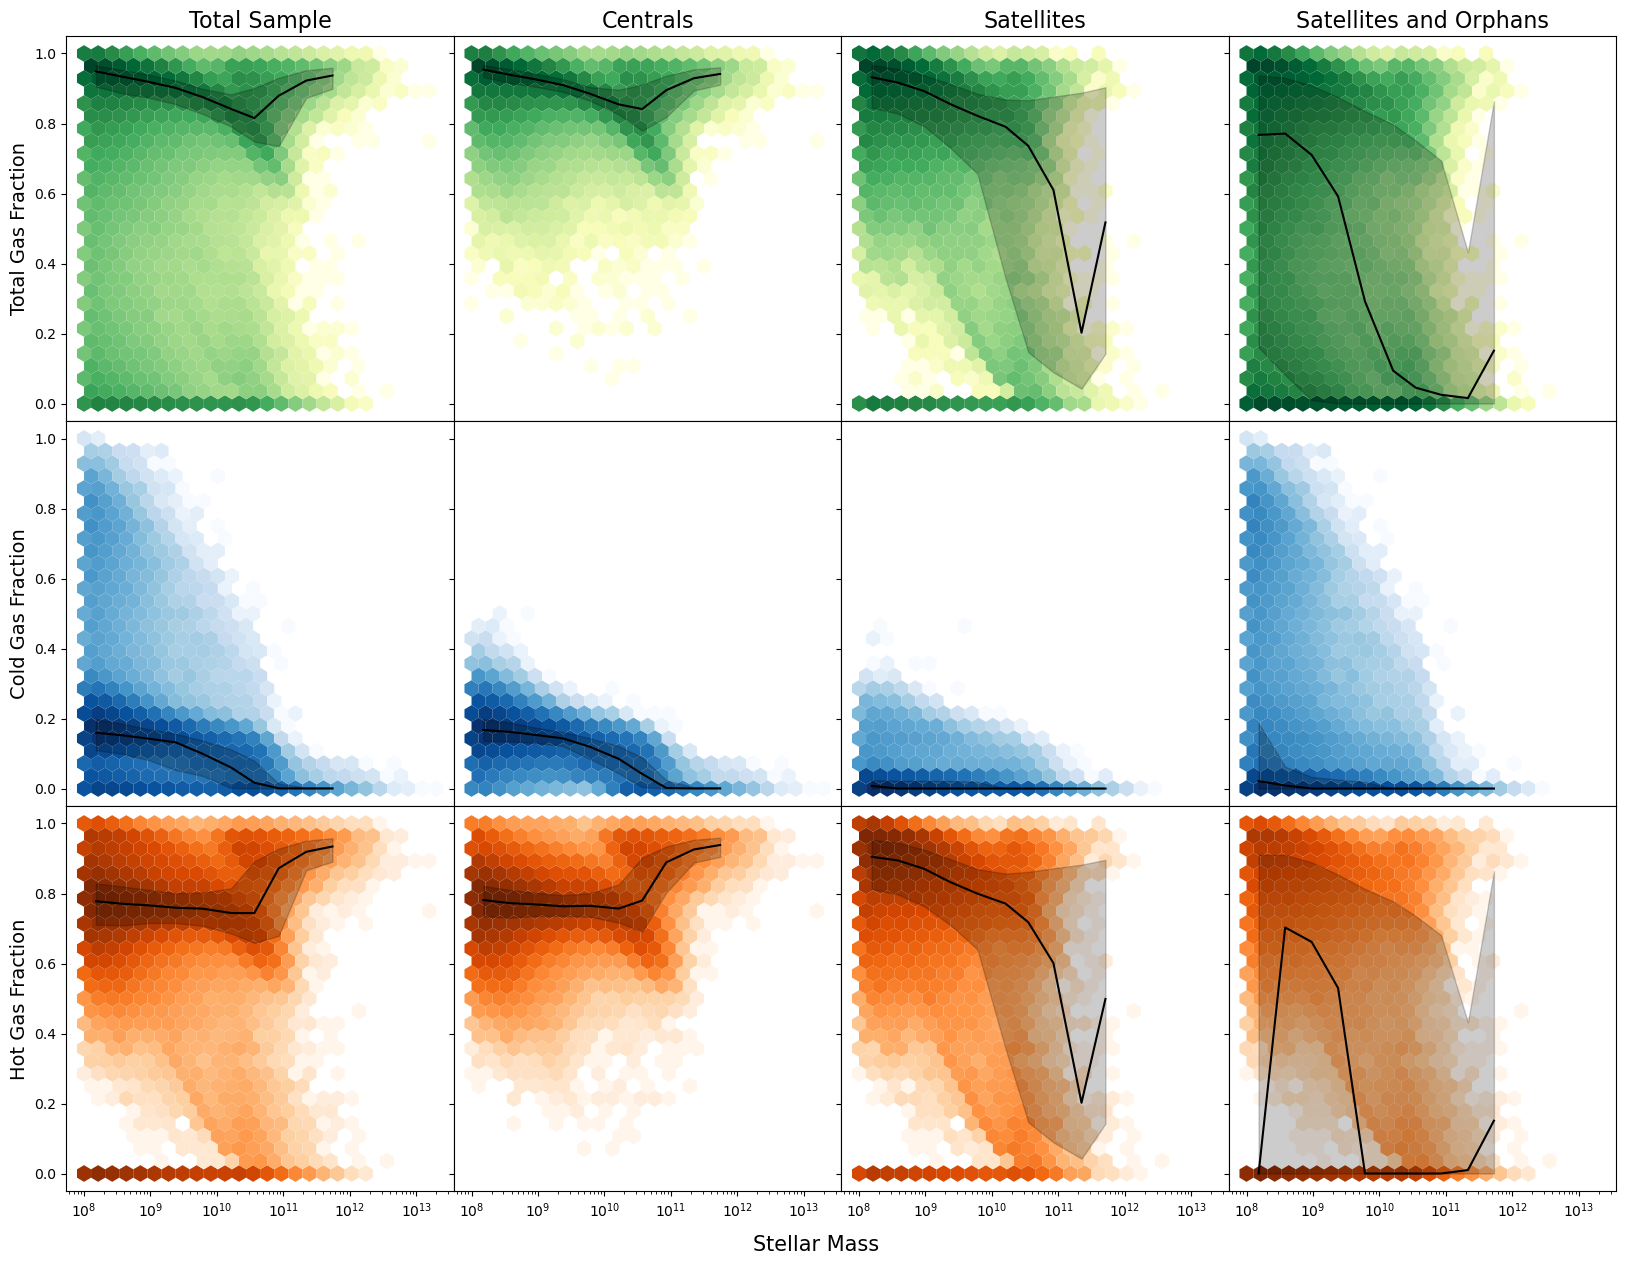

In [50]:
# VS. shark_csv['Mstar_all'] -- IQR Visualization
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

########################################
# Gas Fraction
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

########################################
# Global log bin calculation
########################################
# Calculate min and max log values of Stellar Mass 
lowLog = math.log10(data['Mstar_all'].min())
highLog = math.log10(data['Mstar_all'].max())
print("lowlog:", lowLog)
print("highlog:", highLog)
        
# Round to the nearest whole number for log binning
lowLog = round(lowLog, 0)
highLog = round(highLog, 0)

# Create log bins
num_bins = 10
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)
########################################

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        # Filter SHMR and gas fraction for the current dataset
        STELLARmass = data['Mstar_all']
        #SHMR = np.where(SHMR < SHMR_threshold, SHMR_threshold, SHMR)  # Apply threshold
        gas_fraction_subset = gas_fraction[data.index]# Match gas fraction with the current dataset

        ########################################
        # Median Plotting using global log bins
        ########################################
        # MEDIAN for y-values
        result = binned_statistic(STELLARmass, gas_fraction_subset, statistic='median', bins=logBins)
        bin_medians = result.statistic

        # Calculate xVals by finding the median stellar mass value within each bin
        xVals = []

        for j in range(len(logBins) - 1):
            # Filter data points within the current bin
            bin_data = gas_fraction_subset[(STELLARmass >= logBins[j]) & (STELLARmass < logBins[j+1])]
            
            if len(bin_data) > 0:
                # Median x-value
                xVals.append(np.median(STELLARmass[(STELLARmass >= logBins[j]) & (STELLARmass < logBins[j+1])]))
            else:
                xVals.append(np.nan)
                print('append error')

        # PERCENTILES
        # 25th percentile
        # 25th percentile
        percentile_25 = binned_statistic(STELLARmass, gas_fraction_subset, statistic=lambda values: np.percentile(values, 25), bins=logBins)
        p25 = np.array(percentile_25.statistic)

        # 75th percentile
        percentile_75 = binned_statistic(STELLARmass, gas_fraction_subset, statistic=lambda values: np.percentile(values, 75), bins=logBins)
        p75 = np.array(percentile_75.statistic)

        # Convert xVals, bin_medians to numpy arrays
        xVals = np.array(xVals)
        bin_medians = np.array(bin_medians)

        # Calculate valid bins
        valid_bins = ~np.isnan(xVals) & ~np.isnan(bin_medians) & ~np.isnan(p25) & ~np.isnan(p75)

        # Filter arrays using valid_bins
        xVals = xVals[valid_bins]
        bin_medians = bin_medians[valid_bins]
        p25 = p25[valid_bins]
        p75 = p75[valid_bins]

        # Debug shapes
        print(f"xVals shape: {xVals.shape}")
        print(f"p25 shape: {p25.shape}")
        print(f"p75 shape: {p75.shape}")

        # Plot density hexbin
        axs[row, col].hexbin(
            STELLARmass, gas_fraction_subset, gridsize=25, xscale='log',
            reduce_C_function=np.median, mincnt=1, bins='log', linewidth=0, 
            cmap=colours[row], extent=(8, 13.3, 0, 1)
        )

        # Plot percentiles
        axs[row, col].fill_between(xVals, p25, p75, color='black', alpha=0.2)

        # Configure axes
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (SHMR)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Median line without markers
        axs[row, col].plot(
            xVals, 
            bin_medians, 
            color='black',         # Line color
            linewidth=1.5,         # Line width
            linestyle="-"          # Line style (solid)
        )

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'Stellar Mass', ha='center', fontsize=15)

# Show the plot
plt.show()

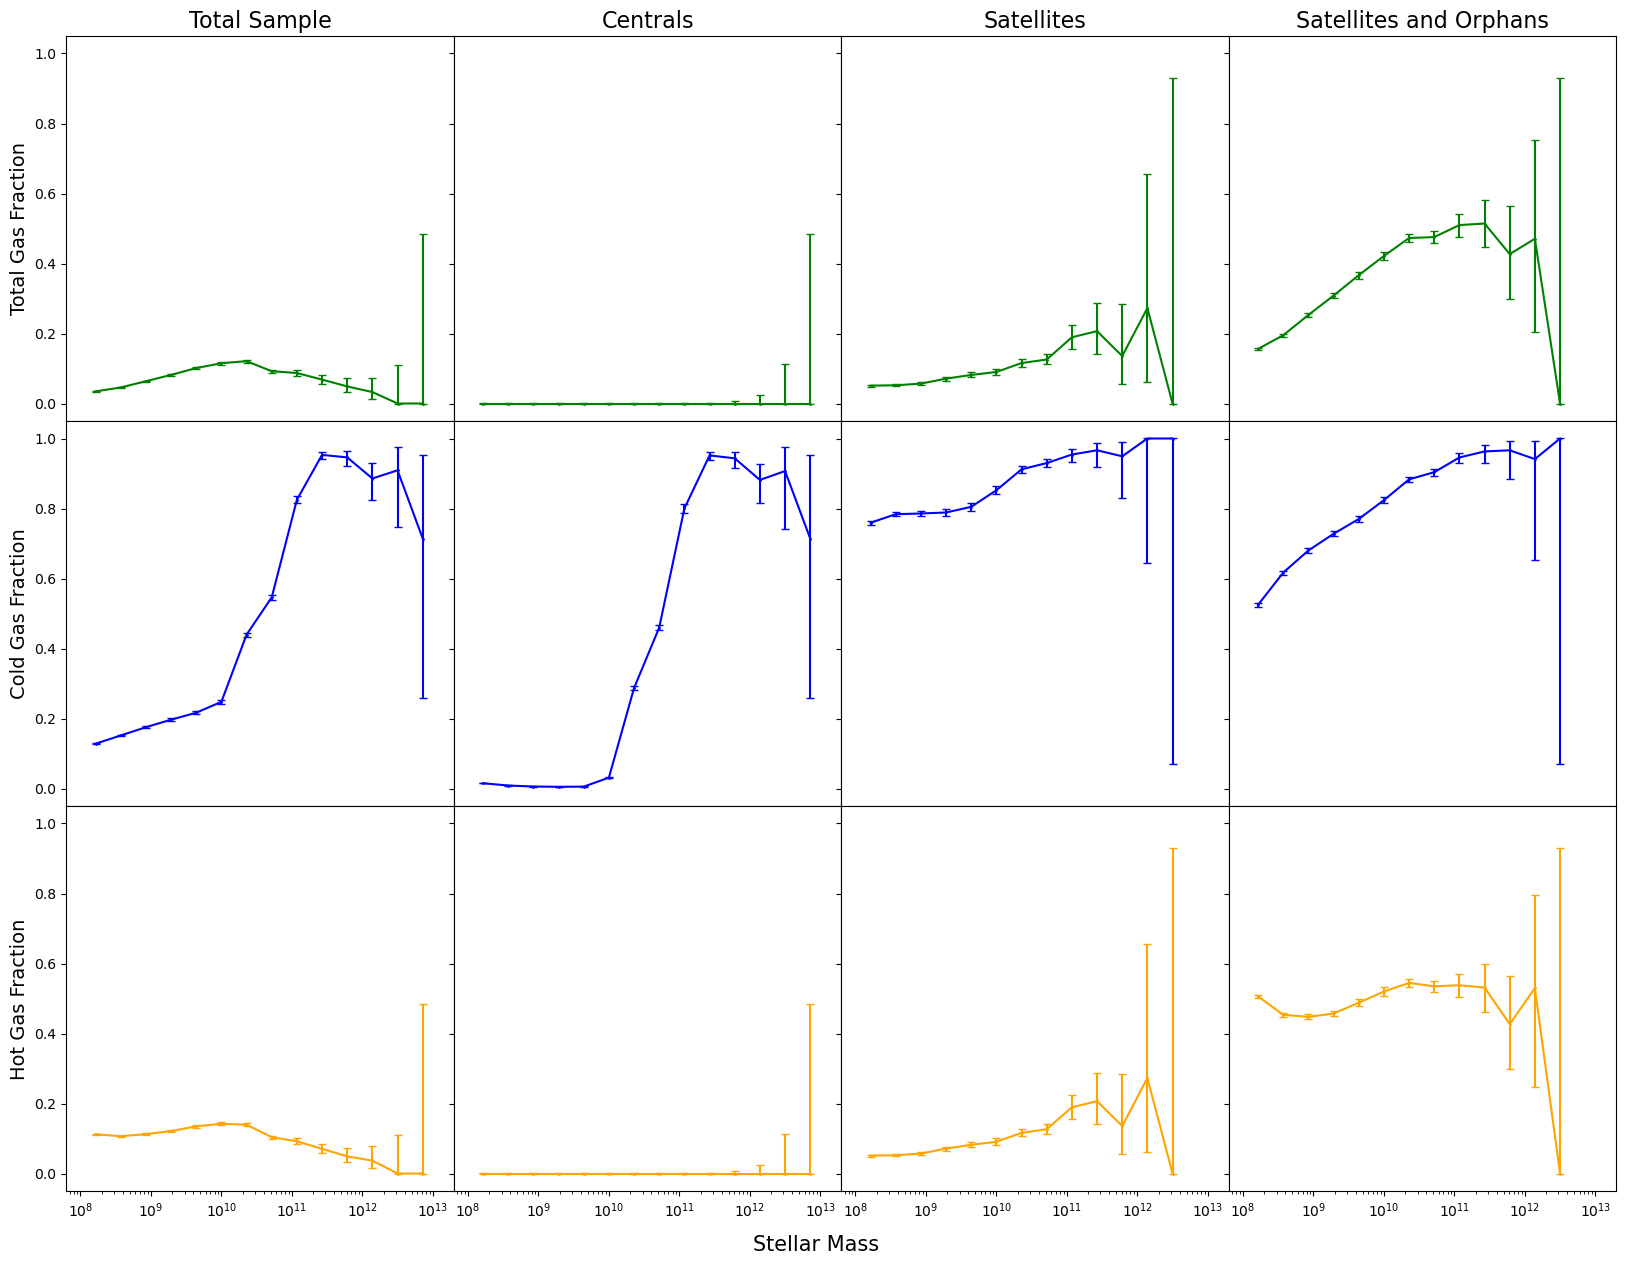

In [80]:
# VS. shark_csv['Mstar_all'] -- ZERO prop. + Bayseian CI
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

SHMR_threshold = 10**-4  # Minimum SHMR to avoid invalid values

def zero_fraction(values, effective_zero=0.025):
    """Compute fraction of values below effective_zero=0.025"""
    if len(values) == 0:
        return np.nan  # Handle empty bins
    count_below = np.count_nonzero(values < effective_zero)  # Count values below threshold
    return count_below / len(values)

# Compute gas fractions
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = shark_csv['Mhotgas'] / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = shark_csv['Mcoldgas_all'] / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
colours = ['Green', 'Blue', 'Orange']

# Create figure and subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Compute log bins
lowLog = math.log10(shark_csv['Mstar_all'].min())
highLog = math.log10(shark_csv['Mstar_all'].max())
lowLog, highLog = round(lowLog, 0), round(highLog, 0)
num_bins = 14
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

# Loop through gas fraction types and datasets
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):
        STELLARmass = data['Mstar_all']
        gas_fraction_subset = gas_fraction[data.index]
        
        # Compute zero fraction per bin
        result = binned_statistic(
            STELLARmass, gas_fraction_subset, 
            statistic=lambda x: zero_fraction(x, effective_zero=0.025), 
            bins=logBins
        )
        zero_fractions, bin_edges = result.statistic, result.bin_edges
        xVals = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin midpoints

        # Filter valid bins
        valid_bins = ~np.isnan(zero_fractions)
        xVals, zero_fractions = xVals[valid_bins], zero_fractions[valid_bins]

        #### GPT CHANGE: Bayesian Confidence Interval Calculation
        ci_lower, ci_upper, xVals_fixed = [], [], []  # Store valid x-values separately
        
        for j in range(len(logBins) - 1):
            bin_data = gas_fraction_subset[(STELLARmass >= logBins[j]) & (STELLARmass < logBins[j+1])]
            
            if len(bin_data) > 0:
                k = np.count_nonzero(bin_data < 0.025)  # Correct success count
                n = len(bin_data)  # Total trials
                xVals_fixed.append((logBins[j] + logBins[j+1]) / 2)  # Use bin midpoint
                
                # Compute Bayesian credible intervals
                lower = beta.ppf(0.005, k + 1, n - k + 1)
                upper = beta.ppf(0.995, k + 1, n - k + 1)
                ci_lower.append(lower)
                ci_upper.append(upper)
            
        # Plot the proportion of values below threshold
        yerr = np.abs(np.vstack((zero_fractions - ci_lower, ci_upper - zero_fractions)))
        
        axs[row, col].errorbar(xVals_fixed, 
            zero_fractions, 
            yerr=yerr, 
            fmt='o', 
            color=colours[row],
            linestyle='-',
            markersize=1,
            capsize=3
        )

        # Set axes properties
        axs[row, col].set_xscale('log')
        axs[row, col].set_yscale('linear')
        axs[row, col].set_xlim(10**7.8, 10**13.3)  # #### GPT CHANGE: Manually set x-axis limits
        axs[row, col].set_ylim(-0.05, 1.05)  # #### GPT CHANGE: Manually set y-axis limits
        
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

# Add shared x-axis label
fig.text(0.5, 0.07, 'Stellar Mass', ha='center', fontsize=15)
plt.show()

lowlog: 8.000002589290592
highlog: 12.453305907192526
LogBins: [1.00000000e+08 3.72759372e+08 1.38949549e+09 5.17947468e+09
 1.93069773e+10 7.19685673e+10 2.68269580e+11 1.00000000e+12]


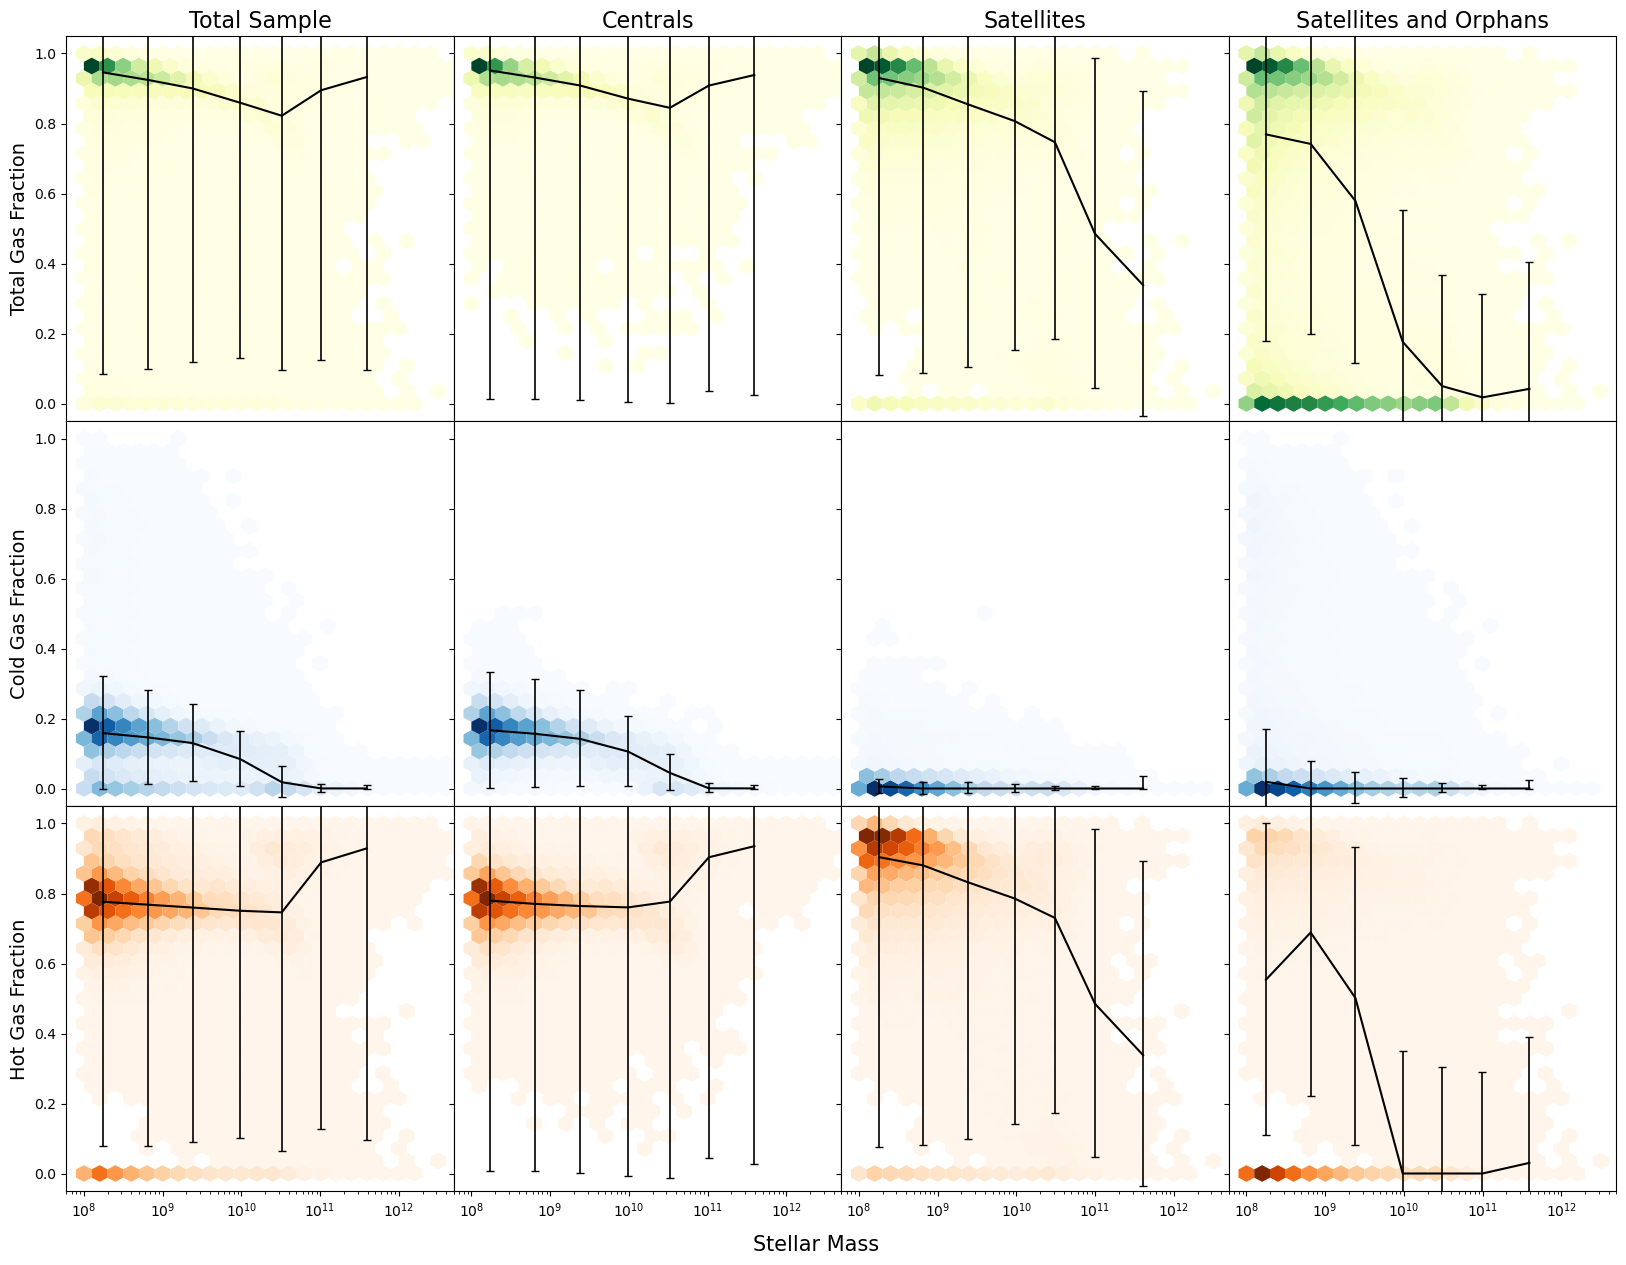

In [54]:
# VS. shark_csv['Mstar_all'] + BIN DATA + Baysian ERRORBARS
# List of datasets for easy iteration
datasets = [
    ("Total Sample", shark_csv), 
    ("Centrals", shark_csv_centrals), 
    ("Satellites", shark_csv_satellites), 
    ("Satellites and Orphans", shark_csv_satANDor)
]

########################################
# Gas Fraction
########################################
# Precompute total_gas_fraction, hot_gas_fraction, and cold_gas_fraction for the entire shark_csv dataset
total_gas_fraction = (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas']) / \
                     (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

hot_gas_fraction = (shark_csv['Mhotgas']) / \
                   (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

cold_gas_fraction = (shark_csv['Mcoldgas_all']) / \
                    (shark_csv['Mcoldgas_all'] + shark_csv['Mhotgas'] + shark_csv['Mstar_all'])

gas_fractions = [total_gas_fraction, cold_gas_fraction, hot_gas_fraction]
labels = ["Total Gas Fraction", "Cold Gas Fraction", "Hot Gas Fraction"]
########################################
colours = ["YlGn","Blues", "Oranges"]

# Create a 3x4 grid of subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharey='row', sharex='col')
fig.subplots_adjust(wspace=0, hspace=0)

# Apply scalar formatting for readability
for ax_row in axs:
    for ax in ax_row:
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

# Set a shared x and y-axis range
y_min = -0.05
y_max = 1.05
x_min = 6*10**7
x_max = 5*10**12

for ax_row in axs:
    for ax in ax_row:
        ax.set_ylim([y_min, y_max])
        ax.set_xlim([x_min, x_max])
        ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability
    
########################################
# Global log bin calculation
########################################
# Calculate min and max log values of Stellar Mass 
lowLog = math.log10(STELLARmass.min())
highLog = math.log10(STELLARmass.max())
print("lowlog:", lowLog)
print("highlog:", highLog)
        
# Round to the nearest whole number for log binning
lowLog = round(lowLog, 0)
highLog = round(highLog, 0)

# Create log bins
num_bins = 7
logBins = np.logspace(lowLog, highLog, num=num_bins + 1)
print("LogBins:", logBins) #DEBUG
########################################

# Loop through each gas fraction type
for row, (gas_fraction, label) in enumerate(zip(gas_fractions, labels)):
    for col, (title, data) in enumerate(datasets):

        STELLARmass = data['Mstar_all']
        gas_fraction_subset = gas_fraction[data.index]
        
        ########################################
        # Median Plotting using global log bins
        ########################################
        # MEDIAN for y-values
        result = binned_statistic(STELLARmass, gas_fraction_subset, statistic='median', bins=logBins)
        bin_medians = result.statistic

        # Calculate xVals by finding the median stellar mass value within each bin
        xVals = []
        ci_lower = []
        ci_upper = []

        for j in range(len(logBins) - 1):
            # Filter data points within the current bin
            bin_data = gas_fraction_subset[(STELLARmass >= logBins[j]) & (STELLARmass < logBins[j+1])]

            ########################################
            # Bayseian confidence intervals
            ########################################
            
            if len(bin_data) > 0:
                # Median x-value
                xVals.append(np.median(STELLARmass[(STELLARmass >= logBins[j]) & (STELLARmass < logBins[j+1])]))

                # Bayesian confidence intervals
                k = bin_data.sum()  # Successes (sum of gas fractions in the bin)
                n = len(bin_data)  # Total data points (trials)

                lower = beta.ppf((1 - 0.95) / 2, k + 1, n - k + 1)  # 95% CI lower bound
                upper = beta.ppf(1 - (1 - 0.95) / 2, k + 1, n - k + 1)  # 95% CI upper bound

                ci_lower.append(lower)
                ci_upper.append(upper)
            else:
                xVals.append(np.nan)
                ci_lower.append(np.nan)
                ci_upper.append(np.nan)
                print("append error")

        # Convert xVals, bin_medians, ci_lower, ci_upper to numpy arrays and remove NaN values
        xVals = np.array(xVals)
        bin_medians = np.array(bin_medians)
        ci_lower = np.array(ci_lower)
        ci_upper = np.array(ci_upper)

        valid_bins = ~np.isnan(xVals) & ~np.isnan(bin_medians)
        xVals = xVals[valid_bins]
        bin_medians = bin_medians[valid_bins]
        ci_lower = ci_lower[valid_bins]
        ci_upper = ci_upper[valid_bins]
        
        ########################################

        # Plot density hexbin
        axs[row, col].hexbin(STELLARmass, gas_fraction_subset, gridsize=25, xscale='log',
                             reduce_C_function=np.median, mincnt=1, linewidth=0, 
                             cmap=colours[row], extent=(8, 13, 0, 1))
        axs[row, col].set_xscale('log')  # Logarithmic x-axis (STELLAR MASS)
        axs[row, col].set_yscale('linear')  # Linear y-axis (gas fraction)

        # Set subplot title for the first row only
        if row == 0:
            axs[row, col].set_title(f'{title}', fontsize=16)

        # Set shared y-axis label on the leftmost column
        if col == 0:
            axs[row, col].set_ylabel(label, fontsize=14)

        #print("ci_lower:", ci_lower, "ci_upper:", ci_upper) #DEBUG

        axs[row, col].errorbar(
            xVals, 
            bin_medians, 
            yerr=(ci_lower, ci_upper),
            fmt='',                # No markers
            ecolor='black',         # Error bar color
            elinewidth=1.2,        # Error bar width
            capsize=3,              # Error bar cap size
            color='black'
        )

fig.text(0.5, 0.07, 'Stellar Mass', ha='center', fontsize=15)

plt.show()